In [1]:
import numpy as np
import pandas as pd
import gc
from multiprocessing import Pool

import cmasher as cmr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning) 
from scipy import stats
from minepy import MINE

path_csv = "/media/temp/bego/snapshots_resim/"
path_datos = "/home/bego/GARROTXA_copia/datos_GARROTXA_resim/"
path_results = "/home/bego/GARROTXA/GalaDyn/results/"
path_crossmatch = "/home/bego/GARROTXA/satelites_crossmatch/"
path_figures_acceleration = "/home/bego/GARROTXA/aceleration_figures/"
path_figures = "/home/bego/GARROTXA/acceleration_figures/"
path_acceleration = "/home/bego/GARROTXA/acceleration/"
path_disk = "/home/bego/GARROTXA/disco/"
seconds_to_Myr = 3.15576e+16

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
df15 = pd.read_csv(path_results + f"10-15kpc_dynamic_data_v2.csv", sep = ",", index_col = 0)
df10 = pd.read_csv(path_results + f"5-10kpc_dynamic_data_v2.csv", sep = ",", index_col = 0)

In [7]:
df15_red = df15.iloc[74:]

In [8]:
df15_red2 = df15_red.drop(["Stars", "Satelites", "All", "DM_out", "DM_inner", "Z", "VZ"], axis = 1)

In [9]:
df15_red2

,Lookback,Bending,Breathing,density,BendingM2,BreathingM2,densityM2,DM,Gas
74,4.972099,2.526155,0.750248,0.070153,2.856630,4.050032,0.049791,9.864048,57.333293
75,4.945596,2.738099,0.669746,0.064698,2.487638,4.207690,0.068599,16.426240,50.253920
76,4.892248,2.719801,1.171244,0.065365,1.929288,4.172387,0.073196,7.945965,51.015060
77,4.862669,2.773915,1.037943,0.066081,2.122338,4.236185,0.071497,9.457373,49.657513
78,4.848723,2.476075,1.076747,0.069780,2.475976,4.286541,0.066505,7.468019,50.052317
...,...,...,...,...,...,...,...,...,...
220,0.140454,0.852107,1.473311,0.337612,0.804046,4.382034,0.086297,14.382300,26.288741
221,0.100925,1.021869,1.461848,0.317252,0.738803,4.346010,0.067800,16.990018,24.561643
222,0.079098,1.065165,1.255009,0.312423,0.837958,4.336350,0.065026,17.210351,30.339461
223,0.057232,1.078219,1.306889,0.306374,0.881425,4.263980,0.066681,10.877019,32.111231


------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.36648256 0.57510875 0.71788628 0.78960944 0.85416502 0.90116002
 0.94382983 0.98310544 1.        ]


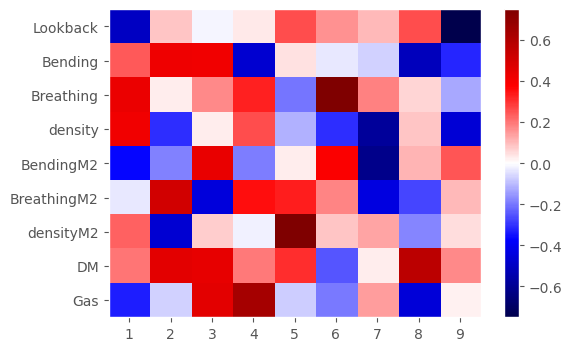

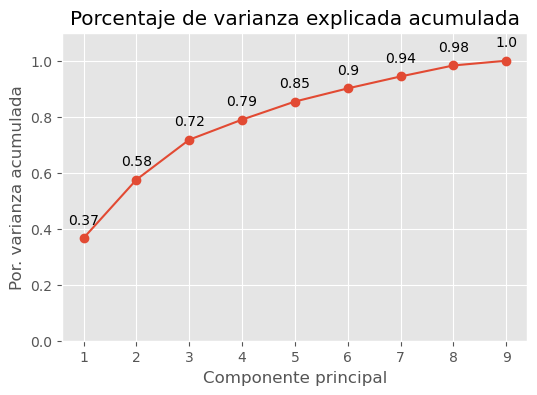

In [39]:
datos = df15_red2

#indices_analizar = ['PC1', 'PC2', 'PC3']
long = 9
indices_analizar= []
for i in range(1,long +1):
    indices_analizar.append(f'PC{i}')
#print(indices_analizar)
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']


# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = datos.columns,
    index   = indices_analizar
)

#print(modelo_pca.components_)
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='seismic', aspect='auto', vmin=-0.75, vmax = 0.75)
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.30337989 0.49809959 0.62721734 0.74570197 0.82525914 0.88320764
 0.93063355 0.97232137 1.        ]


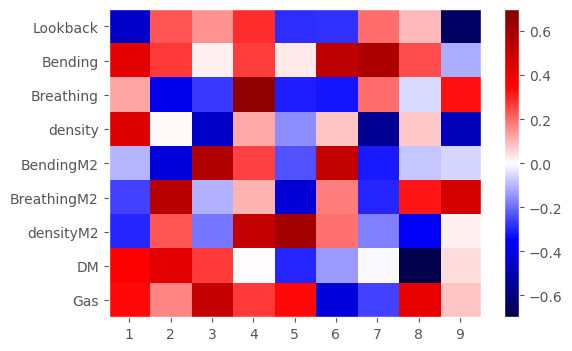

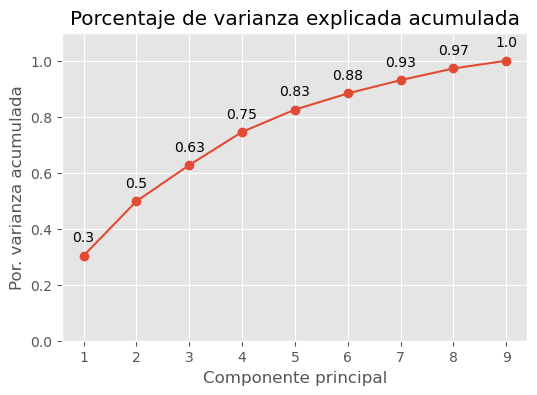

In [36]:
df10_red = df10.iloc[84:]
df10_red2 = df10_red.drop(["Stars", "Satelites", "All", "DM_out", "DM_inner", "Z", "VZ"], axis = 1)
datos = df10_red2

#indices_analizar = ['PC1', 'PC2', 'PC3']
long = 9
indices_analizar= []
for i in range(1,long +1):
    indices_analizar.append(f'PC{i}')
#print(indices_analizar)
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']


# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = datos.columns,
    index   = indices_analizar
)

#print(modelo_pca.components_)
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='seismic', aspect='auto', vmin = -0.7, vmax = 0.7)
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.40982024 0.57171305 0.71132404 0.80476709 0.86978377 0.92947258
 0.96579363 0.9863107  1.        ]


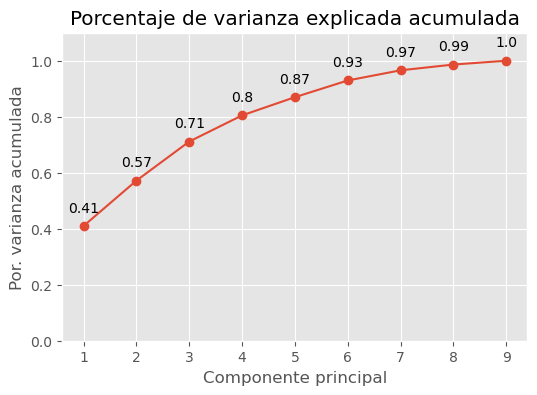

In [27]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

(191, 9)
(191, 2)


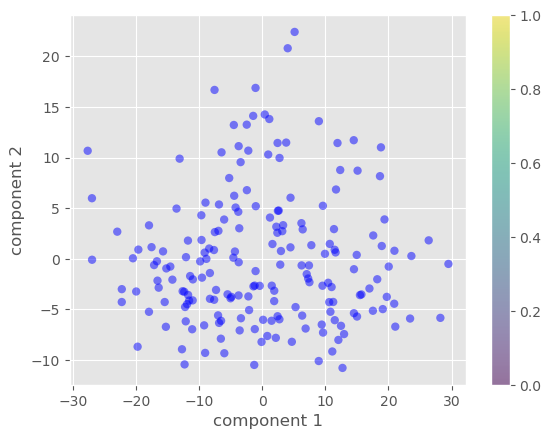

In [42]:


#from sklearn.datasets import load_digits
#digits = load_digits()
#digits.data.shape



pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(datos)
print(datos.shape)
print(projected.shape)
plt.scatter(projected[:, 0], projected[:, 1],
            c="blue", edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


In [10]:
df15_red2

,Lookback,Bending,Breathing,density,BendingM2,BreathingM2,densityM2,DM,Gas
74,4.972099,2.526155,0.750248,0.070153,2.856630,4.050032,0.049791,9.864048,57.333293
75,4.945596,2.738099,0.669746,0.064698,2.487638,4.207690,0.068599,16.426240,50.253920
76,4.892248,2.719801,1.171244,0.065365,1.929288,4.172387,0.073196,7.945965,51.015060
77,4.862669,2.773915,1.037943,0.066081,2.122338,4.236185,0.071497,9.457373,49.657513
78,4.848723,2.476075,1.076747,0.069780,2.475976,4.286541,0.066505,7.468019,50.052317
...,...,...,...,...,...,...,...,...,...
220,0.140454,0.852107,1.473311,0.337612,0.804046,4.382034,0.086297,14.382300,26.288741
221,0.100925,1.021869,1.461848,0.317252,0.738803,4.346010,0.067800,16.990018,24.561643
222,0.079098,1.065165,1.255009,0.312423,0.837958,4.336350,0.065026,17.210351,30.339461
223,0.057232,1.078219,1.306889,0.306374,0.881425,4.263980,0.066681,10.877019,32.111231


In [42]:
df15_red = df15.iloc[74:]
df15_red2 = df15_red.drop(["Stars", "Satelites", "All", "DM_out", "DM_inner", "Z", "VZ"], axis = 1)

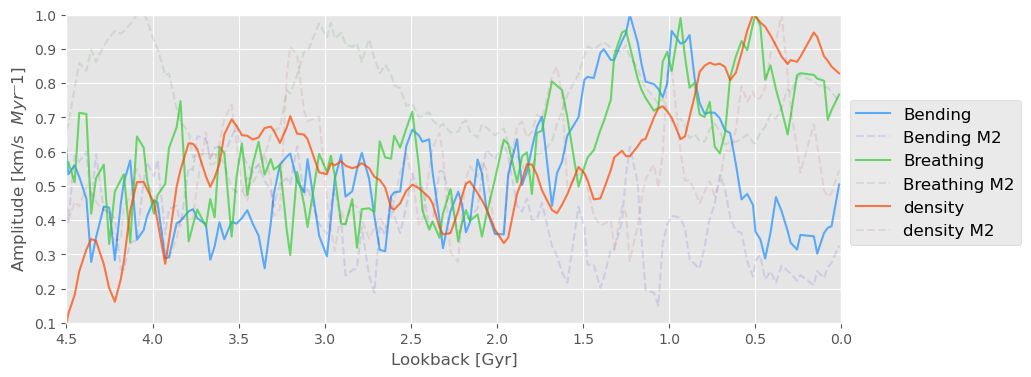

In [34]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(df15_red2["Lookback"],df15_red2["Bending"]/np.max(df15_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp)
ax.plot(df15_red2["Lookback"],df15_red2["BendingM2"]/np.max(df15_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = 0.1)


ax.plot(df15_red2["Lookback"],df15_red2["Breathing"]/np.max(df15_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = transp)
ax.plot(df15_red2["Lookback"],df15_red2["BreathingM2"]/np.max(df15_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = 0.1)


ax.plot(df15_red2["Lookback"],df15_red2["density"]/np.max(df15_red2["density"]),label = "density", c = colors[4], alpha = transp)
ax.plot(df15_red2["Lookback"],df15_red2["densityM2"]/np.max(df15_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = 0.1)
#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(4.5,0)
ax.set_ylim(0.1,1)
ax.legend(fontsize = 12,bbox_to_anchor = (1., 0.75))
ax.grid()
#fig.savefig("test.png")
plt.show()

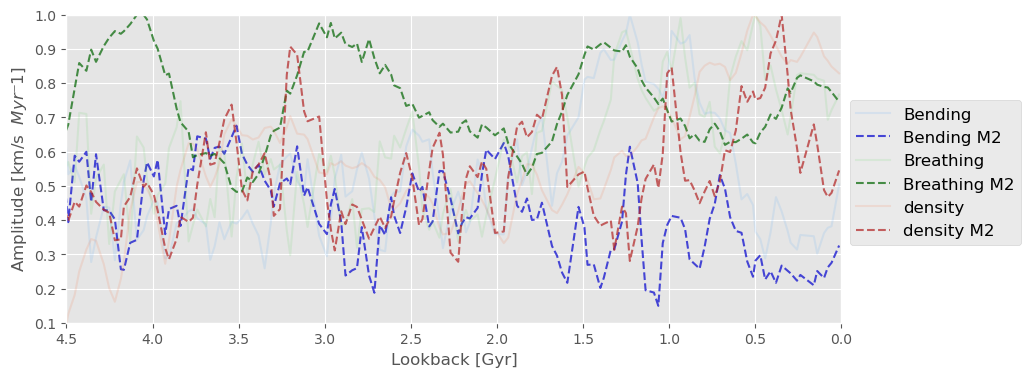

In [35]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(df15_red2["Lookback"],df15_red2["Bending"]/np.max(df15_red2["Bending"]),label = "Bending", c = colors[0], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["BendingM2"]/np.max(df15_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["Breathing"]/np.max(df15_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["BreathingM2"]/np.max(df15_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["density"]/np.max(df15_red2["density"]),label = "density", c = colors[4], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["densityM2"]/np.max(df15_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = transp)
#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(4.5,0)
ax.set_ylim(0.1,1)
ax.legend(fontsize = 12,bbox_to_anchor = (1., 0.75))
ax.grid()
#fig.savefig("test.png")
plt.show()

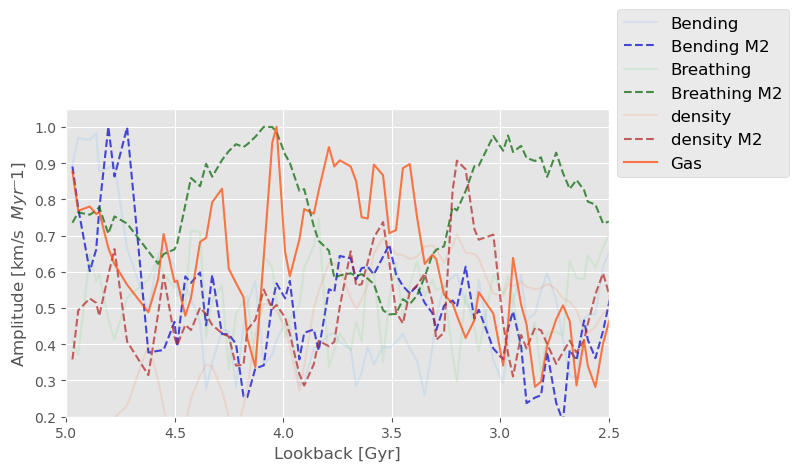

In [46]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(df15_red2["Lookback"],df15_red2["Bending"]/np.max(df15_red2["Bending"]),label = "Bending", c = colors[0], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["BendingM2"]/np.max(df15_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["Breathing"]/np.max(df15_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["BreathingM2"]/np.max(df15_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["density"]/np.max(df15_red2["density"]),label = "density", c = colors[4], alpha = 0.1)
ax.plot(df15_red2["Lookback"],df15_red2["densityM2"]/np.max(df15_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = transp)

ax.plot(df15_red2["Lookback"],df15_red2["Gas"]/np.max(df15_red2["Gas"]),label = "Gas", c = colors[4], alpha = transp)


#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(5,2.5)
ax.set_ylim(0.2,1.05)
ax.legend(fontsize = 12,bbox_to_anchor = (1., 0.75))
ax.grid()
#fig.savefig("test.png")
plt.show()

In [21]:
df10_red = df10.iloc[74:]
df10_red2 = df10_red.drop(["Stars", "Satelites", "All", "DM_out", "DM_inner", "Z", "VZ"], axis = 1)

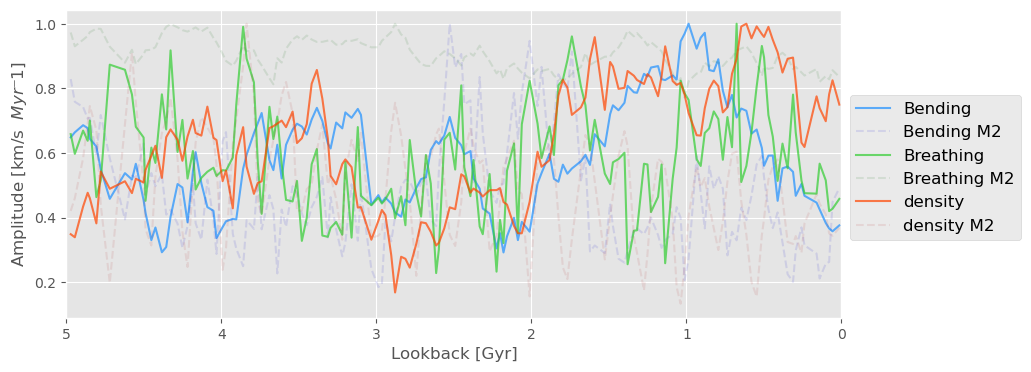

In [24]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(df10_red2["Lookback"],df10_red2["Bending"]/np.max(df10_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BendingM2"]/np.max(df10_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["Breathing"]/np.max(df10_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BreathingM2"]/np.max(df10_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["density"]/np.max(df10_red2["density"]),label = "density", c = colors[4], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["densityM2"]/np.max(df10_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = 0.1)
#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(5,0)
#ax.set_ylim(0,100)
ax.legend(fontsize = 12,bbox_to_anchor = (1., 0.75))
ax.grid()
#fig.savefig("test.png")
plt.show()

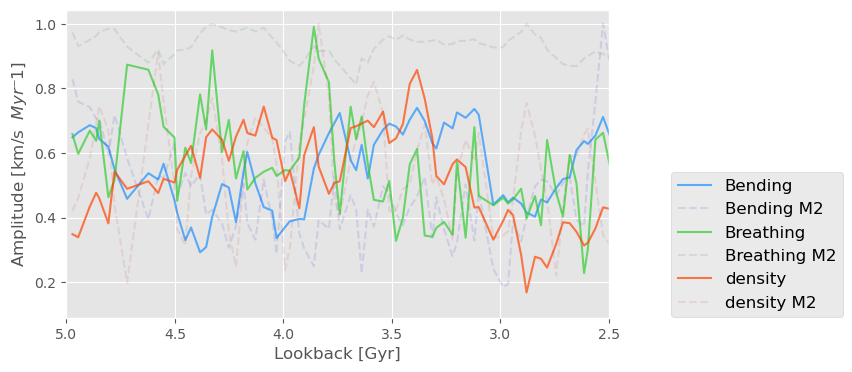

In [39]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(df10_red2["Lookback"],df10_red2["Bending"]/np.max(df10_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BendingM2"]/np.max(df10_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["Breathing"]/np.max(df10_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BreathingM2"]/np.max(df10_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["density"]/np.max(df10_red2["density"]),label = "density", c = colors[4], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["densityM2"]/np.max(df10_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = 0.1)



#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(5,2.5)
#ax.set_ylim(0,100)
ax.legend(fontsize = 12,bbox_to_anchor = (1.1, 0.5))
ax.grid()
#fig.savefig("test.png")
plt.show()

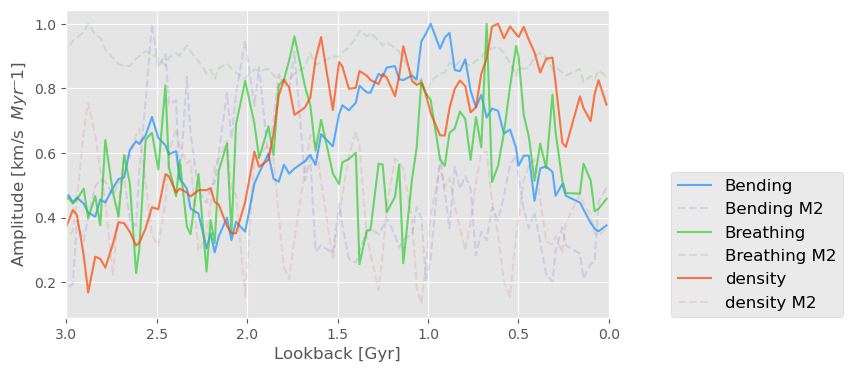

In [47]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(df10_red2["Lookback"],df10_red2["Bending"]/np.max(df10_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BendingM2"]/np.max(df10_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["Breathing"]/np.max(df10_red2["Breathing"]),label = "Breathing", c = colors[2], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["BreathingM2"]/np.max(df10_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = 0.1)


ax.plot(df10_red2["Lookback"],df10_red2["density"]/np.max(df10_red2["density"]),label = "density", c = colors[4], alpha = transp)
ax.plot(df10_red2["Lookback"],df10_red2["densityM2"]/np.max(df10_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = 0.1)



#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(3,0)
#ax.set_ylim(0,100)
ax.legend(fontsize = 12,bbox_to_anchor = (1.1, 0.5))
ax.grid()
#fig.savefig("test.png")
plt.show()

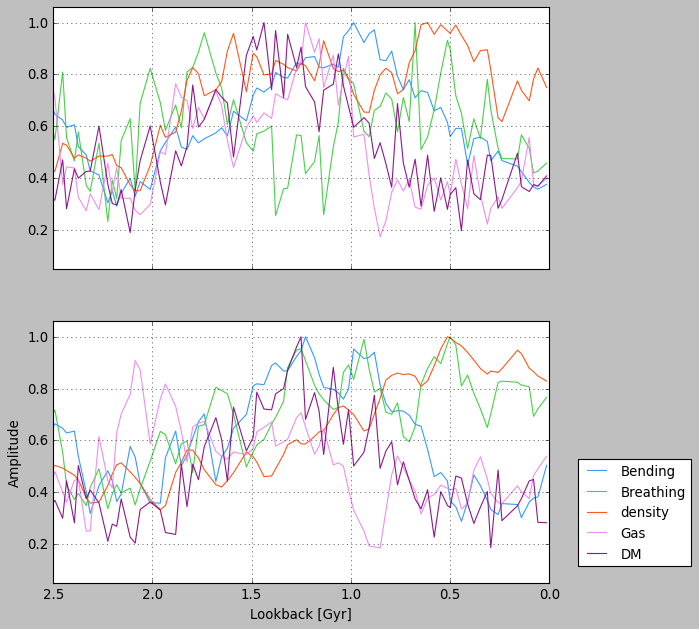

In [77]:
plt.style.use('classic')
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.9
fig, ax = plt.subplots(nrows = 2,figsize = (8,9), sharex= True, sharey = True)
ax[0].plot(df10_red2["Lookback"],df10_red2["Bending"]/np.max(df10_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp, ls = "-")
#ax.plot(df10_red2["Lookback"],df10_red2["BendingM2"]/np.max(df10_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = transp)


ax[0].plot(df10_red2["Lookback"],df10_red2["Breathing"]/np.max(df10_red2["Breathing"]),label = "Breathing", c = colors[2], alpha =transp, ls = "-")
#ax.plot(df10_red2["Lookback"],df10_red2["BreathingM2"]/np.max(df10_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = transp)


ax[0].plot(df10_red2["Lookback"],df10_red2["density"]/np.max(df10_red2["density"]),label = "density", c = colors[4], alpha = transp, ls = "-")
#ax.plot(df10_red2["Lookback"],df10_red2["densityM2"]/np.max(df10_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = transp)

ax[0].plot(df10_red2["Lookback"],df10_red2["Gas"]/np.max(df10_red2["Gas"]),label = "Gas", c = colors[6], alpha = transp, ls = "-")
ax[0].plot(df10_red2["Lookback"],df10_red2["DM"]/np.max(df10_red2["DM"]),label = "DM", c = colors[7], alpha = transp, ls = "-")



ax[1].plot(df15_red2["Lookback"],df15_red2["Bending"]/np.max(df15_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp, ls = "-")
#ax.plot(df15_red2["Lookback"],df15_red2["BendingM2"]/np.max(df15_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = transp)


ax[1].plot(df15_red2["Lookback"],df15_red2["Breathing"]/np.max(df15_red2["Breathing"]),label = "Breathing", c = colors[2], alpha =transp, ls = "-")
#ax.plot(df15_red2["Lookback"],df15_red2["BreathingM2"]/np.max(df15_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = transp)


ax[1].plot(df15_red2["Lookback"],df15_red2["density"]/np.max(df15_red2["density"]),label = "density", c = colors[4], alpha = transp, ls = "-")
#ax.plot(df15_red2["Lookback"],df15_red2["densityM2"]/np.max(df15_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = transp)

ax[1].plot(df15_red2["Lookback"],df15_red2["Gas"]/np.max(df15_red2["Gas"]),label = "Gas", c = colors[6], alpha = transp, ls = "-")
ax[1].plot(df15_red2["Lookback"],df15_red2["DM"]/np.max(df15_red2["DM"]),label = "DM", c = colors[7], alpha = transp, ls = "-")




ax[1].set_xlabel('Lookback [Gyr]', fontsize = 12)
ax[1].set_ylabel('Amplitude', fontsize = 12)
ax[0].grid()
ax[1].grid()
ax[1].set_xlim(2.5,0)
ax[1].set_ylim(0.05,1.06)
ax[1].legend(fontsize = 12,bbox_to_anchor = (1.3, 0.5))

#fig.savefig("test.png")
plt.show()

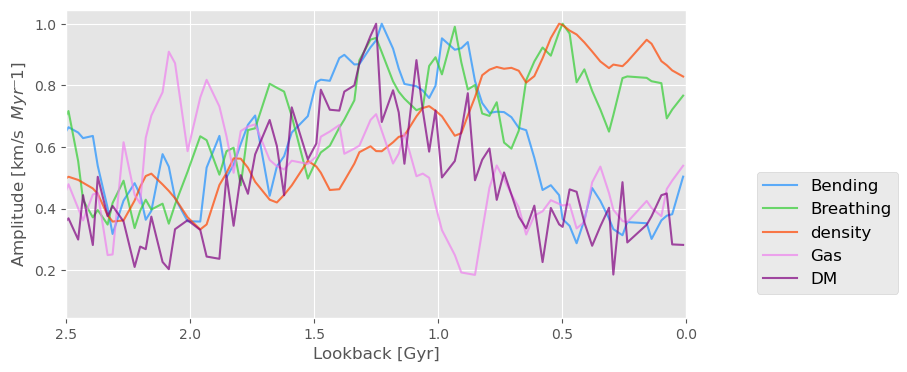

In [58]:
colors = [ "dodgerblue","mediumblue", "limegreen",  "darkgreen", "orangered","firebrick",  "violet","purple", ]
transp = 0.7
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(df15_red2["Lookback"],df15_red2["Bending"]/np.max(df15_red2["Bending"]),label = "Bending", c = colors[0], alpha = transp)
#ax.plot(df15_red2["Lookback"],df15_red2["BendingM2"]/np.max(df15_red2["BendingM2"]),label = "Bending M2", c = colors[1], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["Breathing"]/np.max(df15_red2["Breathing"]),label = "Breathing", c = colors[2], alpha =transp)
#ax.plot(df15_red2["Lookback"],df15_red2["BreathingM2"]/np.max(df15_red2["BreathingM2"]),label = "Breathing M2", c = colors[3], ls = "--", alpha = transp)


ax.plot(df15_red2["Lookback"],df15_red2["density"]/np.max(df15_red2["density"]),label = "density", c = colors[4], alpha = transp)
#ax.plot(df15_red2["Lookback"],df15_red2["densityM2"]/np.max(df15_red2["densityM2"]),label = "density M2", c = colors[5], ls = "--", alpha = transp)

ax.plot(df15_red2["Lookback"],df15_red2["Gas"]/np.max(df15_red2["Gas"]),label = "Gas", c = colors[6], alpha = transp)
ax.plot(df15_red2["Lookback"],df15_red2["DM"]/np.max(df15_red2["DM"]),label = "DM", c = colors[7], alpha = transp)
#ax.plot(lookback,np.array(ac_gas_estimator_5)*seconds_to_Myr +np.array(ac_dm_estimator_5)*seconds_to_Myr ,label = "0-5 DM + gas")
#ax.plot(resim["Snapshot"], resim["Npart"], color = "blue", label = "resimulacion")
ax.set_xlabel('Lookback [Gyr]', fontsize = 12)
ax.set_ylabel('Amplitude [km/s  $Myr{⁻1}$]', fontsize = 12)
ax.grid()
ax.set_xlim(2.5,0)
#ax.set_ylim(0,100)
ax.legend(fontsize = 12,bbox_to_anchor = (1.1, 0.5))
ax.grid()
#fig.savefig("test.png")
plt.show()